<a href="https://colab.research.google.com/github/hank199599/deep_learning_keras_log/blob/main/Chapter5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST 影像訓練卷積神經網路

In [4]:
from keras.datasets import mnist
from keras.utils import to_categorical
from keras import layers
from keras import models
model = models.Sequential()

model.add(layers.Conv2D(32,(3,3),activation='relu',input_shape=(28,28,1)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64,(3,3),activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64,(3,3),activation='relu'))

## 參數的算法
參數 = 過濾器長*寬*輸入通道數*過濾器個數+過濾器個數

In [5]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 3, 3, 64)          36928     
Total params: 55,744
Trainable params: 55,744
Non-trainable params: 0
_________________________________________________________________


最後一個Conv2D層輸出的2D張量必須送到接觸的分類器神經網路  
故需要將3D張量展平為1D張量，才能進行傳遞

In [6]:
model.add(layers.Flatten())
model.add(layers.Dense(64,activation='relu'))
model.add(layers.Dense(10,activation='softmax'))

In [7]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)               

In [8]:
from keras import layers
from keras import models


(train_images,train_labels),(test_images,test_labels) = mnist.load_data()

train_images = train_images.reshape((60000,28,28,1))
train_images = train_images.astype('float32')/255

test_images = test_images.reshape((10000,28,28,1))
test_images = test_images.astype('float32')/255

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

model.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])

model.fit(train_images,train_labels,epochs=5,batch_size=64)

11493376/11490434 [==============================] - 354s 31us/step
Epoch 1/5
938/938 [==============================] - 20s 13ms/step - loss: 0.3957 - accuracy: 0.8772
Epoch 2/5
938/938 [==============================] - 12s 13ms/step - loss: 0.0510 - accuracy: 0.9837
Epoch 3/5
938/938 [==============================] - 12s 13ms/step - loss: 0.0354 - accuracy: 0.9888
Epoch 4/5
938/938 [==============================] - 12s 13ms/step - loss: 0.0250 - accuracy: 0.9926
Epoch 5/5
938/938 [==============================] - 12s 13ms/step - loss: 0.0190 - accuracy: 0.9940


運用測試資料來驗證準確度

In [9]:
test_loss,test_acc = model.evaluate(test_images,test_labels)
test_acc

313/313 [==============================] - 2s 5ms/step - loss: 0.0285 - accuracy: 0.9912


0.9911999702453613

# 卷積層

## 比較
* **密集層**：學習特徵空間中全域的Pattern
* **卷積層**：學習局部的pattern

> 特徵映射圖亦被稱作特徵圖：他本身是一個抽象映射動作  
  
![pic5-1](https://github.com/hank199599/deep_learning_keras_log/blob/main/pictures/5-1.png?raw=true)

## 定義
* 從輸入採樣的區塊大小
* 輸出特徵圖的深度  
　　　　　↓ filter數量　　　　 ↓ 以tuple或list傳入
```python
Conv2D(output_depth,(widow_height,window_width))
```  


## 運作原理
1. 在3D輸入特徵圖上滑動的小窗格，萃取窗格上的3D區塊的特徵  
2. 將每個3D區塊轉換成做張量**shape=(output_depth,)**的1D張量
3. 將所有向量依照空間上的位置排列重新組裝成**shape=(height,width,output_depth)**的3D輸出特徵圖  

> 輸出特徵圖中的每個空間位置和輸入特徵圖中的相同位置相對應  

![pic5-2](https://github.com/hank199599/deep_learning_keras_log/blob/main/pictures/5-2.png?raw=true)

## 可能的問題


### 邊界效應 border effec
![pic5-3](https://github.com/hank199599/deep_learning_keras_log/blob/main/pictures/5-3.png?raw=true)  
透過窗格的滑動萃取特徵圖的同時，  
會使輸出的向量維度發生縮減的情形。

**解決方式**：填補法(padding)  
在輸入特徵圖的每一側增加適當數量的列和行，以便讓每個輸入圖塊都可以讓卷積層的移動窗格掃描到。
```
在Conv2D層中，使用padding參數來設定  
* vaild ；不用填補
* same ： 使用填補方式使輸出輸入具有相同的寬度和高度
```


### 步長(stride)
控制窗格移動的間距  
依此方式進行取樣的卷積層被稱作「**步長設定卷積層**(strided convolutions)」
> 即步長大於1的卷積層


# Maxpooling
從輸入特徵圖中做採樣並輸出樣本的最大值。  
他並非用卷積核(convolution kernel)張量積的方式來轉換的局部區塊


In [10]:
from keras import layers
from keras import models
model_no_max_pool = models.Sequential()
model_no_max_pool.add(layers.Conv2D(32,(3,3),activation='relu',input_shape=(28,28,1)))
model_no_max_pool.add(layers.Conv2D(64,(3,3),activation='relu'))
model_no_max_pool.add(layers.Conv2D(64,(3,3),activation='relu'))

In [11]:
model_no_max_pool.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 22, 22, 64)        36928     
Total params: 55,744
Trainable params: 55,744
Non-trainable params: 0
_________________________________________________________________


# 少量資料從頭訓練
易發生 **overfiting**
* 資料擴增法 (data augmentation)
* 預先訓練神經網路的特徵萃取法 (feature extration with a pretrained network)
* 微調預先訓練神經網路法 (fine-tuning a pretrained network)  
  [這段操作在本機端上執行]

1.建立基礎資料夾

In [1]:
import os,shutil

original_dataset_dir=r'dogs-vs-cats\train'

# 建立基礎資料集路徑
base_dir=r'data\cats_and_dogs_small'
if not os.path.isdir(base_dir):os.mkdir(base_dir)

# 建立訓練資料集路徑
train_dir=os.path.join(base_dir,'train')
if not os.path.isdir(train_dir):os.mkdir(train_dir)

# 建立驗證資料集路徑
validation_dir=os.path.join(base_dir,'validation')
if not os.path.isdir(validation_dir):os.mkdir(validation_dir)

# 建立測試資料集路徑
test_dir=os.path.join(base_dir,'test')
if not os.path.isdir(test_dir):os.mkdir(test_dir)


2.建立貓與狗各自的資料夾

In [2]:
# 建立訓練資料集的貓/狗路徑
train_cats_dir=os.path.join(train_dir,'cats')
if not os.path.isdir(train_cats_dir):os.mkdir(train_cats_dir)

train_dogs_dir=os.path.join(train_dir,'dogs')
if not os.path.isdir(train_dogs_dir):os.mkdir(train_dogs_dir)

# 建立驗證資料集的貓/狗路徑
validation_cats_dir=os.path.join(validation_dir,'cats')
if not os.path.isdir(validation_cats_dir):os.mkdir(validation_cats_dir)

validation_dogs_dir=os.path.join(validation_dir,'dogs')
if not os.path.isdir(validation_dogs_dir):os.mkdir(validation_dogs_dir)

# 建立測試資料集的貓/狗路徑
test_cats_dir=os.path.join(test_dir,'cats')
if not os.path.isdir(test_cats_dir):os.mkdir(test_cats_dir)

test_dogs_dir=os.path.join(test_dir,'dogs')
if not os.path.isdir(test_dogs_dir):os.mkdir(test_dogs_dir)


3.將「cat」圖片進行分組並轉移到對應的資料夾

In [49]:
fnames=['cat.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir,fname)
    dst = os.path.join(train_cats_dir,fname)
    shutil.copyfile(src,dst)

fnames=['cat.{}.jpg'.format(i) for i in range(1000,1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir,fname)
    dst = os.path.join(validation_cats_dir,fname)
    shutil.copyfile(src,dst)

fnames=['cat.{}.jpg'.format(i) for i in range(1500,2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir,fname)
    dst = os.path.join(test_cats_dir,fname)
    shutil.copyfile(src,dst)

In [50]:
fnames=['dog.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir,fname)
    dst = os.path.join(train_dogs_dir,fname)
    shutil.copyfile(src,dst)

fnames=['dog.{}.jpg'.format(i) for i in range(1000,1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir,fname)
    dst = os.path.join(validation_dogs_dir,fname)
    shutil.copyfile(src,dst)

fnames=['dog.{}.jpg'.format(i) for i in range(1500,2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir,fname)
    dst = os.path.join(test_dogs_dir,fname)
    shutil.copyfile(src,dst)

進行檢查：驗證每個訓練/驗證/測試分組中的圖片數量

In [3]:
print("訓練用的貓圖片張數：",len(os.listdir(train_cats_dir)))
print("訓練用的狗圖片張數：",len(os.listdir(train_dogs_dir)))
print("驗證用的貓圖片張數：",len(os.listdir(validation_cats_dir)))
print("驗證用的狗圖片張數：",len(os.listdir(validation_dogs_dir)))
print("測試用的貓圖片張數：",len(os.listdir(test_cats_dir)))
print("測試用的狗圖片張數：",len(os.listdir(test_dogs_dir)))

訓練用的貓圖片張數： 1000
訓練用的狗圖片張數： 1000
驗證用的貓圖片張數： 500
驗證用的狗圖片張數： 500
測試用的貓圖片張數： 500
測試用的狗圖片張數： 500


# 建立神經網路

 組成多個 Conv2D + MaxPolling2D 增強神經網路的能量並降低特徵圖的大小。  
 自 150x150 在最後展平前得到 7x7 的特徵圖。  
 由於欲解決的問題是**二元問題**，  
 因此使用單一單元和sigmoid啟動函數來結束神經網路。

In [20]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32,(3,3),activation='relu',input_shape=(150,150,3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64,(3,3),activation='relu',input_shape=(150,150,3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,(3,3),activation='relu',input_shape=(150,150,3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,(3,3),activation='relu',input_shape=(150,150,3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(512,activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))

In [3]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

由於使用單個Sigmoid單元結束神經網路，  
因此使用二元交叉熵作為損失基準

In [21]:
from keras import optimizers

model.compile(loss='binary_crossentropy',optimizer=optimizers.RMSprop(lr=1e-4),metrics=['acc'])

# 資料預處理步驟
1. 讀取影像檔案
2. 將JPEG內容解碼為RGB的像素
3. 將 RGB像素轉換成浮點數張量
4. 將像素值(0-255之間)壓縮到 [[0,1]] 區間  

實務上：  
```python
keras.perprocesssing.image 之中的 ImageDataGenerator 類別
```

In [22]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen=ImageDataGenerator(rescale=1./255)
test_datagen=ImageDataGenerator(rescale=1./255)

train_generator=train_datagen.flow_from_directory(
    train_dir,              # 目標目錄
    target_size=(150,150),  # 調整所有影像大小為 150 * 150
    batch_size=20,          
    class_mode='binary'     # 因為二元交叉熵binary_crossentropy作為損失值，所以需要二元標籤
)

vaildation_generator=test_datagen.flow_from_directory(
    test_dir,              # 目標目錄
    target_size=(150,150),  # 調整所有影像大小為 150 * 150
    batch_size=20,          
    class_mode='binary'     # 因為二元交叉熵binary_crossentropy作為損失值，所以需要二元標籤
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [23]:
for data_batch,labels_batch in train_generator:
    print('data batch size:',data_batch.shape)
    print('labels batch shape:',labels_batch.shape)
    break

data batch size: (20, 150, 150, 3)
labels batch shape: (20,)


fit_generator：調整model來搭配產生所產生的資料

In [24]:
# 調整 model 以使用批次量產生器
history = model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=vaildation_generator,
    validation_steps=50
)

Epoch 1/30
100/100 [==============================] - 33s 308ms/step - loss: 0.7067 - acc: 0.5071 - val_loss: 0.6794 - val_acc: 0.5440
Epoch 2/30
100/100 [==============================] - 11s 110ms/step - loss: 0.6695 - acc: 0.5898 - val_loss: 0.6704 - val_acc: 0.5790
Epoch 3/30
100/100 [==============================] - 11s 110ms/step - loss: 0.6157 - acc: 0.6641 - val_loss: 0.6237 - val_acc: 0.6530
Epoch 4/30
100/100 [==============================] - 11s 110ms/step - loss: 0.5714 - acc: 0.7085 - val_loss: 0.5918 - val_acc: 0.6920
Epoch 5/30
100/100 [==============================] - 11s 111ms/step - loss: 0.5531 - acc: 0.7184 - val_loss: 0.5967 - val_acc: 0.6820
Epoch 6/30
100/100 [==============================] - 11s 112ms/step - loss: 0.4834 - acc: 0.7707 - val_loss: 0.5671 - val_acc: 0.7020
Epoch 7/30
100/100 [==============================] - 11s 111ms/step - loss: 0.4730 - acc: 0.7759 - val_loss: 0.6009 - val_acc: 0.6760
Epoch 8/30
100/100 [==============================] - 1

In [10]:
model.save('./model/cats_and_dogs_small_1.h5')

繪製每個訓練週期中，model的髓失職與準確度曲線

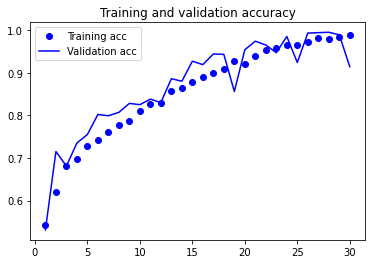

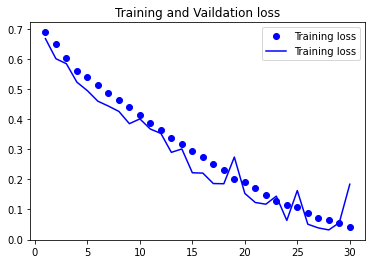

In [11]:
import matplotlib.pyplot as plt 

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(acc)+1)

plt.plot(epochs,acc,'bo',label="Training acc")
plt.plot(epochs,val_acc,'b',label="Validation acc")
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs,loss,'bo',label="Training loss")
plt.plot(epochs,val_loss,"b",label="Training loss")
plt.title("Training and Vaildation loss")
plt.legend()

plt.show()

# 使用資料擴增法
自現有訓練樣本成更多訓練資料的方法  
```
ImageGenerator
```

In [7]:
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

顯示一些隨機擴充後的訓練影像

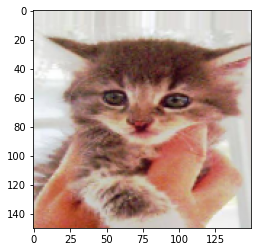

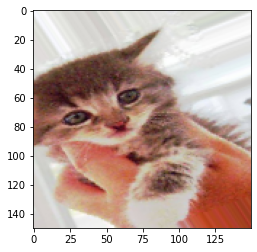

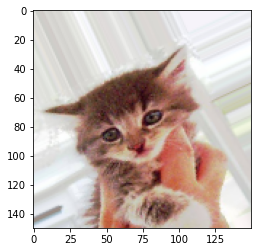

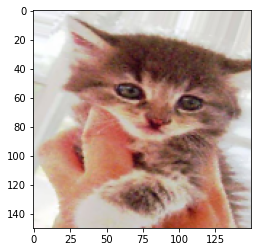

In [10]:
from keras.preprocessing import image
from matplotlib import pyplot as plt 

fnames=[os.path.join(train_cats_dir,fname) for fname in os.listdir(train_cats_dir)]

img_path = fnames[3]
img = image.load_img(img_path,target_size=(150,150))

x = image.img_to_array(img)
x = x.reshape((1,) + x.shape)

i=0
for batch in datagen.flow(x,batch_size=1):
    plt.figure(i)
    implot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break
plt.show()

新增Dropout層來降低發生過度適配的可能性

In [25]:
from keras import layers
from keras import models
from keras import optimizers

model = models.Sequential()
model.add(layers.Conv2D(32,(3,3),activation='relu',input_shape=(150,150,3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64,(3,3),activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,(3,3),activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,(3,3),activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512,activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer=optimizers.RMSprop(lr=1e-4),metrics=['acc'])

### 使用資料擴增跟丟棄法來訓練神經網路

In [34]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True, )

test_datagen = ImageDataGenerator(rescale=1./255) # 驗證資料不應該進行擴充

train_generator = train_datagen.flow_from_directory(
	train_dir,    # 目標目錄
	target_size=(150, 150), # 所有圖像大小調整成 150×150 
	batch_size=32,
	class_mode='binary') # 因為使用二元交叉熵 binary_crossentropy 作為損失，所以需要二元標籤


vaildation_generator=test_datagen.flow_from_directory(
    test_dir,              # 目標目錄
    target_size=(150,150),  # 調整所有影像大小為 150 * 150
    batch_size=20,          
    class_mode='binary'     # 因為二元交叉熵binary_crossentropy作為損失值，所以需要二元標籤
)

# 訓練
history = model.fit(   
	train_generator,
	# steps_per_epoch=100, # 一般都讓TF自行判斷，不須特別設定(在這裡加入會噴ERROR)
	epochs=100,
	validation_data=validation_generator,
	validation_steps=50)


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/100
63/63 [==============================] - 20s 321ms/step - loss: 0.2937 - acc: 0.8745 - val_loss: 0.4136 - val_acc: 0.8380
Epoch 2/100
63/63 [==============================] - 18s 277ms/step - loss: 0.2981 - acc: 0.8730
Epoch 3/100
63/63 [==============================] - 17s 275ms/step - loss: 0.2971 - acc: 0.8670
Epoch 4/100
63/63 [==============================] - 18s 278ms/step - loss: 0.3068 - acc: 0.8710
Epoch 5/100
63/63 [==============================] - 17s 274ms/step - loss: 0.3010 - acc: 0.8645
Epoch 6/100
63/63 [==============================] - 17s 270ms/step - loss: 0.2820 - acc: 0.8760
Epoch 7/100
63/63 [==============================] - 17s 270ms/step - loss: 0.2901 - acc: 0.8765
Epoch 8/100
63/63 [==============================] - 17s 271ms/step - loss: 0.2865 - acc: 0.8760
Epoch 9/100
63/63 [==============================] - 17s 270ms/step - loss: 0.2842 - acc: 0.8815
Epoch 

儲存模型

In [33]:
model.save('./model/cats_and_dogs_small_2.h5')

再次繪圖進行驗證

In [28]:
import matplotlib.pyplot as plt 

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(acc)+1)

plt.plot(epochs,acc,'bo',label="Training acc")
plt.plot(epochs,val_acc,'b',label="Validation acc")
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs,loss,'bo',label="Training loss")
plt.plot(epochs,val_loss,"b",label="Validation loss")
plt.title("Training and Vaildation loss")
plt.legend()

plt.show()

ValueError: x and y must have same first dimension, but have shapes (100,) and (1,)

# 使用預先訓練的神經網路

* 特徵萃取 (feature extration)
* 微調 (fine-tuning)

## 特徵萃取
使用先前神經網路所學習到的表示法，自新的樣本中萃取出對應的特徵
  
用於影像分類的卷積神經網路的組成：
 * 卷積基底(**卷積層+池化層**)： 學習到參數的空間特徵，通用性高
 * 分類器：僅學習到該樣本對應標籤的可能機率，僅適用於model訓練時所使用的data
  
綜合上述，在實務上的做法：  
**透過convolutionalbase 卷積基底處理新資料，並以輸出結果訓練新的分類器**  
![pic5-4](https://github.com/hank199599/deep_learning_keras_log/blob/main/pictures/5-4.png?raw=true)  


model層的深度決定普適程度
* 較早的神經層： 萃取局部的、高度通用的特徵圖
* 較晚的神經層： 萃取更抽象的概念(例如*貓耳朵*)

實際建立一個VGG16 model

In [16]:
from keras.applications import VGG16

conv_base  = VGG16(
    weights='imagenet',     # 初始化model的權重檢查點
    include_top=False,      # 指在頂部是否有包含密集連接的分類器
    input_shape=(150,150,3) # 提供給神經網路的影像張量的shape
    )

58892288/58889256 [==============================] - 19s 0us/step


In [17]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

資料流動方向是由下而上，因此輸入與輸出的圖片大小是：
* 輸入層：(4,4,512) 
* 輸出層：(150,150,3) 

### 沒有資料擴增的快速萃取特徵

In [41]:
import os
import numpy as np 
from keras.preprocessing.image import ImageDataGenerator
import tqdm

base_dir="./data/cats_and_dogs_small"

train_dir = os.path.join(base_dir,'train')
validation_dir = os.path.join(base_dir,'validation')
test_dir=os.path.join(base_dir,'test')

datagen= ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory,sample_count):
    features = np.zeros(shape=(sample_count,4,4,512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(directory,
                                            target_size=(150,150),
                                            batch_size=batch_size,
                                            class_mode='binary')
    
    i=0
    for inputs_batch,labels_batch in tqdm.tqdm(generator):
        features_batch = conv_base.predict(inputs_batch) # 從批次影像中萃取特徵
        features[i*batch_size:(i+1)*batch_size] = features_batch
        labels[i*batch_size:(i+1)*batch_size] = labels_batch
        i += 1
        # print(i,end=" ")
        # 當萃取的樣本數超過設定的樣本數，則執行break中斷處理
        if i*batch_size >= sample_count:
            break
    return features,labels

trian_features,train_labels = extract_features(train_dir,2000)
validation_features , validation_labels= extract_features(validation_dir,1000)
test_features,test_labels = extract_features(test_dir,1000)

 98%|█████████▊| 49/50 [00:16<00:00,  2.94it/s]50 


為了提供輸出結果給分類器，需要額外進行資料展平

In [43]:
train_features = np.reshape(trian_features,(2000,4*4*512))
validation_features = np.reshape(validation_features,(1000,4*4*512))
test_features = np.reshape(test_features,(1000,4*4*512))

建立和訓練密集連接的分類器

In [45]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256,activation='relu',input_dim=4*4*512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1,activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features,train_labels,
                epochs=30,
                batch_size=20,
                validation_data=(validation_features,validation_labels))

Epoch 1/30
100/100 [==============================] - 2s 12ms/step - loss: 0.7395 - acc: 0.5511 - val_loss: 0.4610 - val_acc: 0.8290
Epoch 2/30
100/100 [==============================] - 1s 10ms/step - loss: 0.4838 - acc: 0.7715 - val_loss: 0.3667 - val_acc: 0.8570
Epoch 3/30
100/100 [==============================] - 1s 10ms/step - loss: 0.3766 - acc: 0.8391 - val_loss: 0.3344 - val_acc: 0.8610
Epoch 4/30
100/100 [==============================] - 1s 10ms/step - loss: 0.3479 - acc: 0.8504 - val_loss: 0.3050 - val_acc: 0.8810
Epoch 5/30
100/100 [==============================] - 1s 10ms/step - loss: 0.2944 - acc: 0.8774 - val_loss: 0.2913 - val_acc: 0.8830
Epoch 6/30
100/100 [==============================] - 1s 11ms/step - loss: 0.2786 - acc: 0.8918 - val_loss: 0.2716 - val_acc: 0.8950
Epoch 7/30
100/100 [==============================] - 1s 10ms/step - loss: 0.2295 - acc: 0.9108 - val_loss: 0.2635 - val_acc: 0.8970
Epoch 8/30
100/100 [==============================] - 1s 10ms/step - 

繪製結果

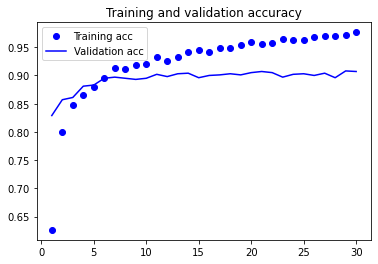

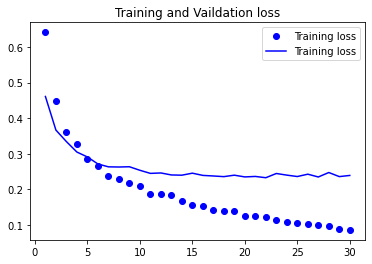

In [46]:
import matplotlib.pyplot as plt 

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(acc)+1)

plt.plot(epochs,acc,'bo',label="Training acc")
plt.plot(epochs,val_acc,'b',label="Validation acc")
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs,loss,'bo',label="Training loss")
plt.plot(epochs,val_loss,"b",label="Validation loss")
plt.title("Training and Vaildation loss")
plt.legend()

plt.show()

儘管使用相當大的丟棄率，資料在一開始就過度配適

### 資料擴增的特徵擷取
執行速度慢、成本昂貴，但允許在訓練期間使用資料擴增法。

In [47]:
from keras import models
from keras import layers
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',include_top=False,input_shape=(150,150,3))

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten()) #展平
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))

In [48]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_5 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 256)               2097408   
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


#### Freeze 凍結 
代表該模型將在訓練期間被禁止更新權重  
在keras中，透過設定trainable的屬性為**False**來進行凍結 卷積神經網路

In [51]:
print('This is the number of traonable weights before freezing the conv_base',len(model.trainable_weights))

This is the number of traonable weights before freezing the conv_base 30


使用此設定後，只需訓練兩個Dense層的權重。  
共有4個權重張量：每層兩個(主要權重矩陣跟偏差向量)

In [53]:
conv_base.trainable=False

In [54]:
print('This is the number of traonable weights after freezing the conv_base',len(model.trainable_weights))

This is the number of traonable weights after freezing the conv_base 4


使用資料擴增設定來訓練model

In [55]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150,150),
    batch_size=20,
    class_mode='binary'
)

vaildation_generator = test_datagen.flow_from_directory(
    test_dir,              # 目標目錄
    target_size=(150,150),  # 調整所有影像大小為 150 * 150
    batch_size=20,          
    class_mode='binary'  
)

model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.RMSprop(lr=2e-5),
    metrics=['acc'])

history = model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=vaildation_generator,
    validation_steps=50
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 [==============================] - 37s 358ms/step - loss: 0.6533 - acc: 0.6139 - val_loss: 0.4585 - val_acc: 0.8230
Epoch 2/30
100/100 [==============================] - 35s 349ms/step - loss: 0.4979 - acc: 0.7709 - val_loss: 0.3831 - val_acc: 0.8390
Epoch 3/30
100/100 [==============================] - 35s 349ms/step - loss: 0.4538 - acc: 0.8011 - val_loss: 0.3487 - val_acc: 0.8490
Epoch 4/30
100/100 [==============================] - 35s 349ms/step - loss: 0.4061 - acc: 0.8263 - val_loss: 0.3172 - val_acc: 0.8760
Epoch 5/30
100/100 [==============================] - 36s 357ms/step - loss: 0.3933 - acc: 0.8241 - val_loss: 0.3065 - val_acc: 0.8760
Epoch 6/30
100/100 [==============================] - 41s 407ms/step - loss: 0.3779 - acc: 0.8337 - val_loss: 0.2920 - val_acc: 0.8800
Epoch 7/30
100/100 [==============================] - 46s 458ms/step - loss: 0.3572 - acc: 0.8430 - val_lo

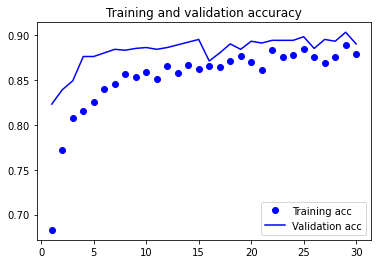

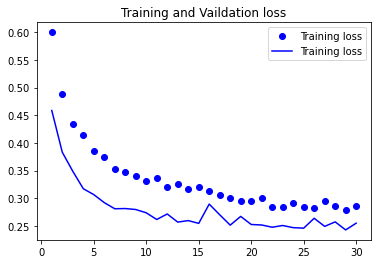

In [56]:
import matplotlib.pyplot as plt 

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(acc)+1)

plt.plot(epochs,acc,'bo',label="Training acc")
plt.plot(epochs,val_acc,'b',label="Validation acc")
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs,loss,'bo',label="Training loss")
plt.plot(epochs,val_loss,"b",label="Validation loss")
plt.title("Training and Vaildation loss")
plt.legend()

plt.show()